# Selecting the Regularization Parameter in the Distribution of Relaxation Times

In [35]:
import general_fun_v8 as general_fun
import importlib
importlib.reload(general_fun)
from numpy import inf, sin, cos, cosh, pi, exp, log10
from math import sqrt, log
import numpy as np
from numpy.linalg import norm
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import time

In [36]:
# set the fonts
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

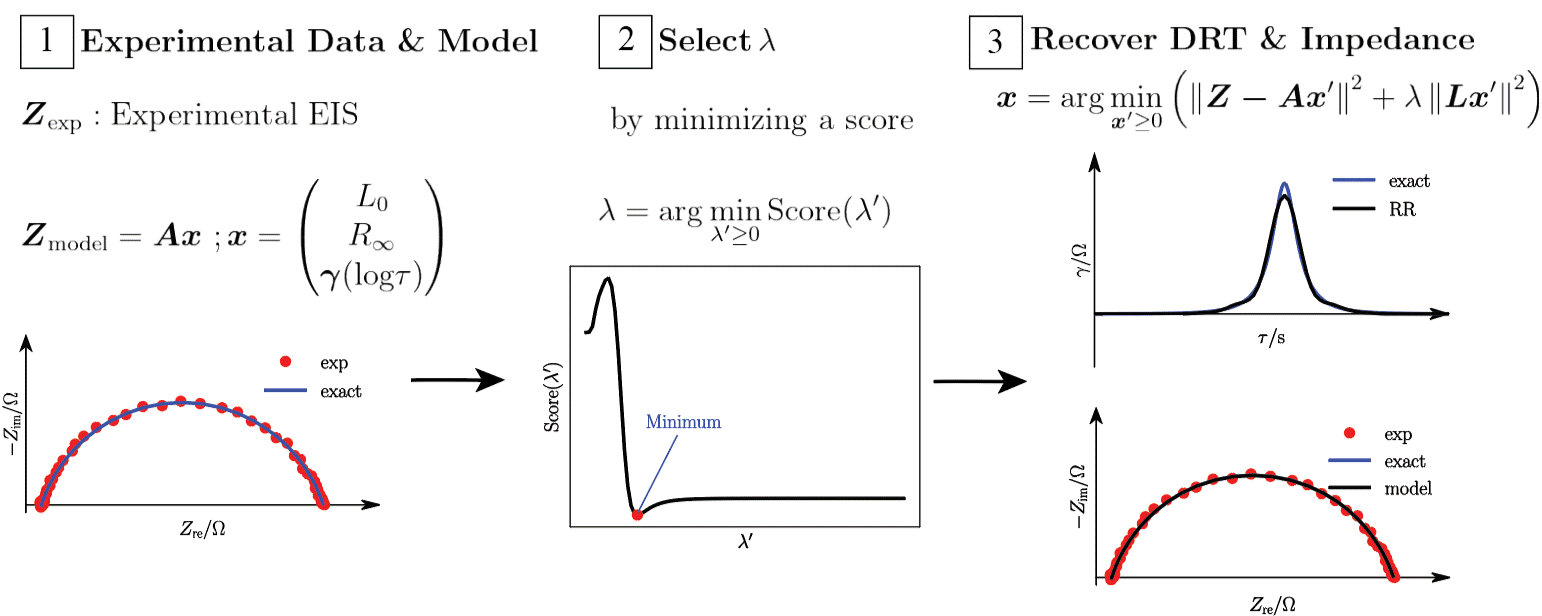

# The 1xZARC model

The DRT and corresponding impedance of the 1xZARC model are given by

$$
\gamma(\log \tau) =  \displaystyle \frac{\displaystyle R_{\rm ct}}{\displaystyle 2\pi} \displaystyle \frac{\displaystyle \sin\left((1-\phi)\pi\right)}{\displaystyle \cosh(\phi \log(\tau/\tau_0))-\cos(\pi(1-\phi))}
$$


$$
Z_{\rm exact}(f) = R_\infty + \displaystyle \frac{R_{\rm ct}}{\displaystyle 1+ \left(i 2\pi f \tau_0\right)^\phi}
$$

# 1. Generate artificial data 

## 1.1 Frequency range

In [37]:
N_freqs = 81 # number of frequencies
freq_min = 10**-2 # frequency range 10^(-2) Hz - 10^6 Hz
freq_max = 10**6
freq_vec = np.logspace(log10(freq_min), log10(freq_max), num=N_freqs, endpoint=True)
tau_vec = np.logspace(-log10(freq_max), -log10(freq_min), num=N_freqs, endpoint=True)
omega_vec = 2.*pi*freq_vec
N_taus = tau_vec.shape[0]

## 1.2 Parameters of the 1xZARC model

In [38]:
R_inf = 10 # Ohm
R_ct = 50 # Ohm
phi = 0.8 # unitless
tau_0 = 0.02 # s

In [39]:
# for plotting
freq_vec_plot = np.logspace(log10(freq_min), log10(freq_max), num=10*(N_freqs-1), endpoint=True)
tau_vec_plot = np.logspace(-log10(freq_max), -log10(freq_min), num=10*(N_freqs-1), endpoint=True)
gamma_exact_plot = (R_ct)/(2.*pi)*sin((1.-phi)*pi)/(np.cosh(phi*np.log(tau_vec_plot/tau_0))-cos((1.-phi)*pi))

## 1.3 Exact DRT and impedance

In [40]:
# exact DRT
gamma_exact = (R_ct)/(2.*pi)*sin((1.-phi)*pi)/(np.cosh(phi*np.log(tau_vec/tau_0))-cos((1.-phi)*pi))

# exact impedance
Z_exact = R_inf+R_ct/(1.0+(1j*2.*pi*freq_vec*tau_0)**phi) 

## 1.4 Artificial impedance

To obtain the experimental impedance $Z_{\rm exp}$, we perturbate the exact impedance $Z_{\rm exact}$ with white noise 

$$ 
{Z}_{\rm exp} = Z_{\rm exact} + \epsilon 
$$
where 
$$
\epsilon \sim \sigma_{n}^{exp} \mathcal{N}(0, 1)
$$

In [41]:
rng = np.random.seed(121295) # seeds
sigma_n_exp = 0.2
error = np.random.normal(0, 1,N_freqs)+1j*np.random.normal(0, 1,N_freqs) # epsilon
Z_exp = Z_exact + sigma_n_exp*error

## 1.5 Nyquist plot of the exact and artificial impedances

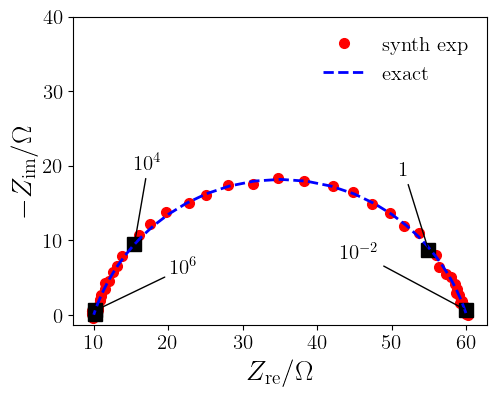

In [42]:
plt.plot(np.real(Z_exp), -np.imag(Z_exp), 'o', markersize=7, color='red', label='synth exp')
plt.plot(np.real(Z_exp[5:81:16]), -np.imag(Z_exp[5:81:16]), 's', markersize=10, color='black')
plt.plot(np.real(Z_exact), -np.imag(Z_exact), '--', linewidth=2, color='blue', label='exact')

plt.legend(frameon=False, fontsize = 15)
plt.axis('scaled')

plt.xticks(range(10, 70, 10))
plt.yticks(range(0, 50, 10))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)

# # label the frequency points
plt.annotate(r'$10^{-2}$', xy=(np.real(Z_exp[5]), -np.imag(Z_exp[5])), 
             xytext=(np.real(Z_exp[5])-17, 7-np.imag(Z_exp[5])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$1$', xy=(np.real(Z_exp[21]), -np.imag(Z_exp[21])), 
             xytext=(np.real(Z_exp[21])-4, 10-np.imag(Z_exp[21])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$10^{4}$', xy=(np.real(Z_exp[37]), -np.imag(Z_exp[37])), 
             xytext=(np.real(Z_exp[37]), 10-np.imag(Z_exp[37])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$10^{6}$', xy=(np.real(Z_exp[53]), -np.imag(Z_exp[53])), 
             xytext=(np.real(Z_exp[53])+10, 5-np.imag(Z_exp[53])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))

fig = plt.gcf()
fig.set_size_inches(6.472, 4)
plt.show()

# 2. The DRTtools

## 2.1 Function  and Parameters for DRT Analysis

In [43]:
der_used = '1st' # type of derivative used in the regularization term
lambda_value = 1E-2
shape_control = 'FWHM'
coeff = 0.5
#expansion_type = 'PWL'
#expansion_type = 'Gaussian'
#expansion_type = 'C0 Matern'
#expansion_type = 'C2 Matern'
#expansion_type = 'C4 Matern'
#expansion_type = 'C6 Matern'
expansion_type = 'Inverse Quadratic'
#expansion_type = 'Inverse Quadric'
#expansion_type = 'Cauchy'
data_used = 're+im'
include_RL = 'R'
derivative_RR = '1st'

epsilon =  general_fun.compute_epsilon(freq_vec, coeff, expansion_type, shape_control)

## 2.2 Definition of the matrices A, M, and Z

In [44]:
A_re, A_im, A =  general_fun.assemble_A(freq_vec, tau_vec, expansion_type, epsilon, include_RL, brute_force = True)
M =  general_fun.assemble_M(tau_vec, expansion_type, epsilon, derivative_RR, include_RL)
Z_re, Z_im, Z =  general_fun.assemble_Z(Z_exp)

# 3. Determination of $\lambda\$

We can estimate $\boldsymbol{\gamma}$ by minimizing the sum $\mathcal{L}_{\rm DRT}$ of square residuals between the experimental impedance $\boldsymbol{Z}$ and the DRT impedance $\boldsymbol{Z}_{\rm DRT}$ 

$$\begin{equation}
   \mathcal{L}_{\rm DRT} = \|\boldsymbol{Z}-\boldsymbol{Ax}\|^{2}
\end{equation}
$$
where 
$$ 
\boldsymbol{Z} = \begin{pmatrix}\boldsymbol{Z}_{\rm exp,re}\\\boldsymbol{Z}_{\rm exp,im}\end{pmatrix} \in \mathbb R^{2M} 
$$

$$
\,\boldsymbol{x} =\begin{pmatrix} 
      L_{0}\\
      R_{\infty}\\
      \boldsymbol{\gamma}
      \end{pmatrix} \in \mathbb R^{N+2}
$$

and 

$$
Z_{\rm DRT} = \mathbf{A}x
$$

where we define $\boldsymbol{A}_{\rm re} = \left( \mathbf{0},\mathbf{1},\boldsymbol{A}_{\gamma,\rm re} \right), \boldsymbol{A}_{\rm im} = \left( 2\pi\boldsymbol{f},\mathbf{0},\boldsymbol{A}_{\gamma,\rm im} \right) \rm{and}\,\, \mathbf{A} = \begin{pmatrix}\boldsymbol{A}_{\rm re}\\\boldsymbol{A}_{\rm im}\end{pmatrix}$ with $\mathbf{0}$ the zero vector of $\mathbb{R}^M, \boldsymbol{A}_{\rm re} \,\rm{and}\, \boldsymbol{A}_{\rm im} \in \mathbb{R}^{M\times(N+2)} \,\rm{and}\, \mathbf{A} \in \mathbb{R}^{2M\times 2(N+2)}$.


Given the ill-posed nature of the DRT problem, an additional penalty term is needed to ensure the smoothness of the DRT solution

$$
\begin{equation}
   \mathcal{L}_{\rm DRT} = \|\boldsymbol{Z}-\boldsymbol{Ax}\|^{2}
\end{equation} + \lambda\|\boldsymbol{Lx}\|^{2}
$$
We consider six different parameter regularization methods to wisely select the regularization parameter $\lambda$, from which we deconvolve the DRT as a solution of the following:
$$
\begin{equation}
   \boldsymbol{x} = \underset{\boldsymbol{x}\geq 0}{\operatorname{argmin}} \mathcal{L}_{\rm DRT}
 \end{equation}
$$

## 3.1 Generalized Cross-Validation (GCV)

### 3.1.1 Computation of $\lambda_{\rm GCV}$

In [45]:
start_time = time.time()

log_lambda_0 = log(10**-3) # initial guess of lambda
cv_type = 'GCV'
lambda_GCV = general_fun.optimal_lambda(A_re, A_im, Z_re, Z_im, M, log_lambda_0, cv_type) # computation of lambda

end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04860840200378788
            Iterations: 1
            Function evaluations: 2
            Gradient evaluations: 1
GCV
0.0


### 3.1.2 GCV-based DRT and Impedance Recoveries

In [46]:
# enforce the non-negativity constraint on the DRT
lb = np.zeros([N_freqs+1])
bound_mat = np.eye(lb.shape[0]) 

# determination of x with cvxopt
H_combined, c_combined = general_fun.quad_format_combined(A_re, A_im, Z_re, Z_im, M, lambda_GCV)
start_time = time.time()
x_GCV = general_fun.cvxopt_solve_qpr(H_combined, c_combined, -bound_mat, lb) 

# determination of gamma
gamma_RR_GCV = general_fun.x_to_gamma(x_GCV[1:], tau_vec, tau_vec, expansion_type, epsilon) 
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

# error of the DRT approximation compared to gamma_exact
sq_err_GCV = norm(gamma_RR_GCV - gamma_exact)**2/norm(gamma_exact)**2 

     pcost       dcost       gap    pres   dres
 0: -1.0571e+05 -1.0610e+05  1e+03  1e+01  4e-03
 1: -1.0570e+05 -1.0582e+05  2e+02  1e+00  5e-04
 2: -1.0571e+05 -1.0574e+05  3e+01  6e-15  2e-16
 3: -1.0572e+05 -1.0572e+05  4e+00  4e-15  2e-16
 4: -1.0572e+05 -1.0572e+05  8e-01  4e-15  2e-16
 5: -1.0572e+05 -1.0572e+05  2e-01  4e-15  2e-16
 6: -1.0572e+05 -1.0572e+05  5e-02  6e-15  2e-16
 7: -1.0572e+05 -1.0572e+05  9e-03  5e-15  2e-16
 8: -1.0572e+05 -1.0572e+05  2e-03  4e-15  1e-16
 9: -1.0572e+05 -1.0572e+05  3e-04  5e-15  2e-16
10: -1.0572e+05 -1.0572e+05  1e-05  4e-15  2e-16
11: -1.0572e+05 -1.0572e+05  3e-07  3e-15  2e-16
12: -1.0572e+05 -1.0572e+05  1e-08  4e-15  2e-16
13: -1.0572e+05 -1.0572e+05  2e-10  5e-15  2e-16
14: -1.0572e+05 -1.0572e+05  2e-12  4e-15  2e-16
Optimal solution found.
0.04519081115722656


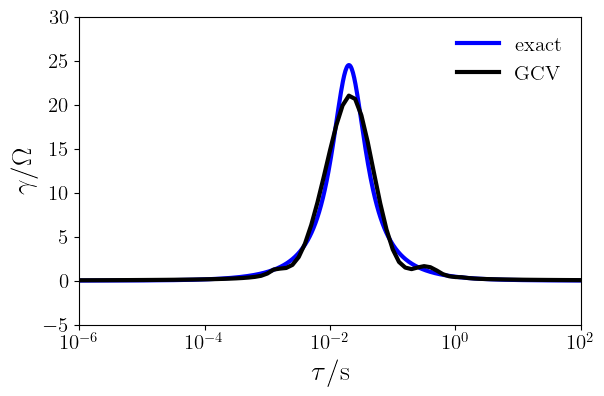

In [47]:
plt.semilogx(tau_vec_plot, gamma_exact_plot, linewidth=3, color='blue', label= 'exact')
plt.semilogx(tau_vec, gamma_RR_GCV, linewidth=3, color='black', label='GCV') 
plt.axis([1E-6,1E2,-5,30])
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.legend(frameon=False, fontsize = 15)
plt.xlabel('$\\tau/\\rm s$', fontsize=20)
plt.ylabel('$\\gamma/\\Omega$', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(6.472, 4)
plt.show()

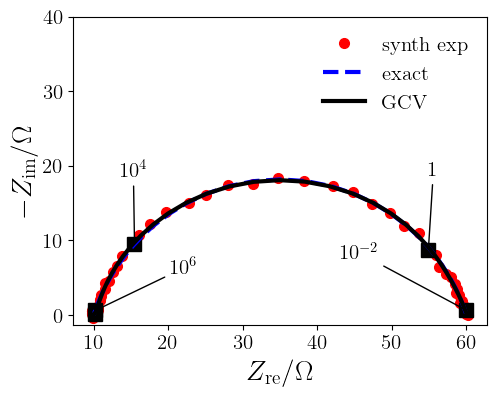

In [48]:
# compute the impedance
Z_DRT_GCV = A@x_GCV
Z_DRT_GCV = Z_DRT_GCV[0:N_freqs] + 1j*Z_DRT_GCV[N_freqs:] 

# Nyquist plot of the impedance
plt.plot(np.real(Z_exp), -np.imag(Z_exp), 'o', markersize=7, color='red', label='synth exp')
plt.plot(np.real(Z_exp[5:81:16]), -np.imag(Z_exp[5:81:16]), 's', markersize=10, color='black')
plt.plot(np.real(Z_exact), -np.imag(Z_exact), '--', linewidth=3, color='blue', label='exact')
plt.plot(np.real(Z_DRT_GCV), -np.imag(Z_DRT_GCV), linewidth=3, color='black', label='GCV')

plt.legend(frameon=False, fontsize = 15)
plt.axis('scaled')

plt.xticks(range(10, 70, 10))
plt.yticks(range(0, 50, 10))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)

plt.annotate(r'$10^{-2}$', xy=(np.real(Z_exp[5]), -np.imag(Z_exp[5])), 
             xytext=(np.real(Z_exp[5])-17, 7-np.imag(Z_exp[5])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$1$', xy=(np.real(Z_exp[21]), -np.imag(Z_exp[21])), 
             xytext=(np.real(Z_exp[21]), 10-np.imag(Z_exp[21])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$10^{4}$', xy=(np.real(Z_exp[37]), -np.imag(Z_exp[37])), 
             xytext=(np.real(Z_exp[37])-2, 9-np.imag(Z_exp[37])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$10^{6}$', xy=(np.real(Z_exp[53]), -np.imag(Z_exp[53])), 
             xytext=(np.real(Z_exp[53])+10, 5-np.imag(Z_exp[53])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))

fig = plt.gcf()
fig.set_size_inches(6.472, 4)
plt.show()

## 3.2 modified General Cross-Validation (mGCV)

### 3.2.1 Computation of $\lambda_{\rm mGCV}$

In [49]:
start_time = time.time()
cv_type = 'mGCV'
lambda_mGCV = general_fun.optimal_lambda(A_re, A_im, Z_re, Z_im, M, log_lambda_0, cv_type)
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05982361122231798
            Iterations: 7
            Function evaluations: 15
            Gradient evaluations: 7
mGCV
0.012999534606933594


### 3.2.2 mGCV-based DRT and Impedance Recoveries

In [50]:
# enforce the non-negativity constraint on the DRT
lb = np.zeros([N_freqs+1])
bound_mat = np.eye(lb.shape[0]) 

# determination of x with cvxopt
H_combined, c_combined = general_fun.quad_format_combined(A_re, A_im, Z_re, Z_im, M, lambda_mGCV)
start_time = time.time()
x_mGCV = general_fun.cvxopt_solve_qpr(H_combined, c_combined, -bound_mat, lb) 

# determination of gamma
gamma_RR_mGCV = general_fun.x_to_gamma(x_mGCV[1:], tau_vec, tau_vec, expansion_type, epsilon) 
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

# error of the DRT approximation compared to gamma_exact
sq_err_mGCV = norm(gamma_RR_mGCV - gamma_exact)**2/norm(gamma_exact)**2 

     pcost       dcost       gap    pres   dres
 0: -1.0570e+05 -1.0610e+05  1e+03  1e+01  4e-03
 1: -1.0570e+05 -1.0582e+05  2e+02  1e+00  4e-04
 2: -1.0571e+05 -1.0573e+05  3e+01  6e-02  2e-05
 3: -1.0572e+05 -1.0572e+05  4e+00  5e-03  2e-06
 4: -1.0572e+05 -1.0572e+05  8e-01  7e-04  3e-07
 5: -1.0572e+05 -1.0572e+05  2e-01  3e-15  2e-16
 6: -1.0572e+05 -1.0572e+05  4e-02  3e-15  2e-16
 7: -1.0572e+05 -1.0572e+05  5e-03  6e-15  2e-16
 8: -1.0572e+05 -1.0572e+05  3e-04  3e-15  2e-16
 9: -1.0572e+05 -1.0572e+05  8e-06  4e-15  2e-16
10: -1.0572e+05 -1.0572e+05  1e-07  4e-15  2e-16
11: -1.0572e+05 -1.0572e+05  1e-09  3e-15  2e-16
12: -1.0572e+05 -1.0572e+05  1e-11  5e-15  2e-16
Optimal solution found.
0.037994384765625


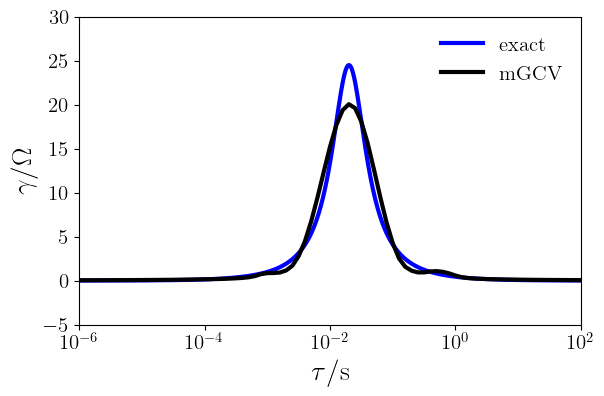

In [51]:
plt.semilogx(tau_vec_plot, gamma_exact_plot, linewidth=3, color='blue', label= 'exact')
plt.semilogx(tau_vec, gamma_RR_mGCV, linewidth=3, color='black', label='mGCV') 
plt.axis([1E-6,1E2,-5,30])
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.legend(frameon=False, fontsize = 15)
plt.xlabel('$\\tau/\\rm s$', fontsize=20)
plt.ylabel('$\\gamma/\\Omega$', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(6.472, 4)
plt.show()

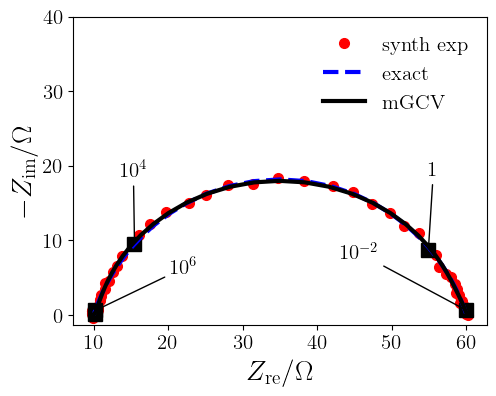

In [52]:
# compute the impedance
Z_DRT_mGCV = A@x_mGCV
Z_DRT_mGCV = Z_DRT_mGCV[0:N_freqs] + 1j*Z_DRT_mGCV[N_freqs:] 

# Nyquist plot of the impedance
plt.plot(np.real(Z_exp), -np.imag(Z_exp), 'o', markersize=7, color='red', label='synth exp')
plt.plot(np.real(Z_exp[5:81:16]), -np.imag(Z_exp[5:81:16]), 's', markersize=10, color='black')
plt.plot(np.real(Z_exact), -np.imag(Z_exact), '--', linewidth=3, color='blue', label='exact')
plt.plot(np.real(Z_DRT_mGCV), -np.imag(Z_DRT_mGCV), linewidth=3, color='black', label='mGCV')

plt.legend(frameon=False, fontsize = 15)
plt.axis('scaled')

plt.xticks(range(10, 70, 10))
plt.yticks(range(0, 50, 10))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)

plt.annotate(r'$10^{-2}$', xy=(np.real(Z_exp[5]), -np.imag(Z_exp[5])), 
             xytext=(np.real(Z_exp[5])-17, 7-np.imag(Z_exp[5])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$1$', xy=(np.real(Z_exp[21]), -np.imag(Z_exp[21])), 
             xytext=(np.real(Z_exp[21]), 10-np.imag(Z_exp[21])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$10^{4}$', xy=(np.real(Z_exp[37]), -np.imag(Z_exp[37])), 
             xytext=(np.real(Z_exp[37])-2, 9-np.imag(Z_exp[37])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$10^{6}$', xy=(np.real(Z_exp[53]), -np.imag(Z_exp[53])), 
             xytext=(np.real(Z_exp[53])+10, 5-np.imag(Z_exp[53])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))

fig = plt.gcf()
fig.set_size_inches(6.472, 4)
plt.show()

## 3.3 Robust Generalized Cross-Validation (rGCV)

### 3.3.1 Computation of $\lambda_{\rm rGCV}$

In [53]:
start_time = time.time()
cv_type = 'rGCV'
lambda_rGCV = general_fun.optimal_lambda(A_re, A_im, Z_re, Z_im, M, log_lambda_0, cv_type)
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.018103063815868927
            Iterations: 1
            Function evaluations: 2
            Gradient evaluations: 1
rGCV
0.003000497817993164


### 3.3.2 rGCV-based DRT and Impedance Recoveries

In [54]:
# enforce the non-negativity constraint on the DRT
lb = np.zeros([N_freqs+1])
bound_mat = np.eye(lb.shape[0]) 

# determination of x with cvxopt
H_combined, c_combined = general_fun.quad_format_combined(A_re, A_im, Z_re, Z_im, M, lambda_rGCV)
start_time = time.time()
x_rGCV = general_fun.cvxopt_solve_qpr(H_combined, c_combined, -bound_mat, lb) 

# determination of gamma
gamma_RR_rGCV = general_fun.x_to_gamma(x_rGCV[1:], tau_vec, tau_vec, expansion_type, epsilon) 
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

# error of the DRT approximation compared to gamma_exact
sq_err_rGCV = norm(gamma_RR_rGCV - gamma_exact)**2/norm(gamma_exact)**2 

     pcost       dcost       gap    pres   dres
 0: -1.0571e+05 -1.0610e+05  1e+03  1e+01  4e-03
 1: -1.0570e+05 -1.0582e+05  2e+02  1e+00  5e-04
 2: -1.0571e+05 -1.0574e+05  3e+01  6e-15  2e-16
 3: -1.0572e+05 -1.0572e+05  4e+00  4e-15  2e-16
 4: -1.0572e+05 -1.0572e+05  8e-01  4e-15  2e-16
 5: -1.0572e+05 -1.0572e+05  2e-01  4e-15  2e-16
 6: -1.0572e+05 -1.0572e+05  5e-02  6e-15  2e-16
 7: -1.0572e+05 -1.0572e+05  9e-03  5e-15  2e-16
 8: -1.0572e+05 -1.0572e+05  2e-03  4e-15  1e-16
 9: -1.0572e+05 -1.0572e+05  3e-04  5e-15  2e-16
10: -1.0572e+05 -1.0572e+05  1e-05  4e-15  2e-16
11: -1.0572e+05 -1.0572e+05  3e-07  3e-15  2e-16
12: -1.0572e+05 -1.0572e+05  1e-08  4e-15  2e-16
13: -1.0572e+05 -1.0572e+05  2e-10  5e-15  2e-16
14: -1.0572e+05 -1.0572e+05  2e-12  4e-15  2e-16
Optimal solution found.
0.03999805450439453


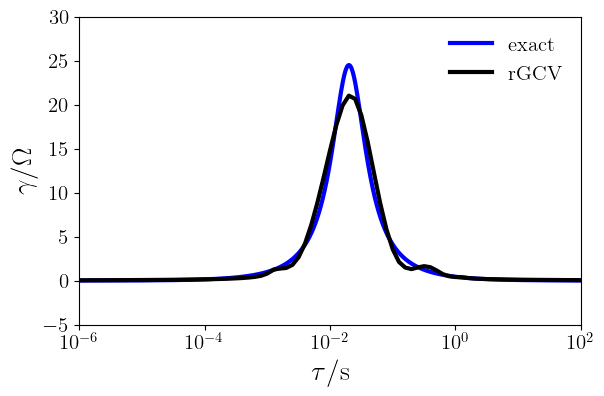

In [55]:
plt.semilogx(tau_vec_plot, gamma_exact_plot, linewidth=3, color='blue', label= 'exact')
plt.semilogx(tau_vec, gamma_RR_rGCV, linewidth=3, color='black', label='rGCV') 
plt.axis([1E-6,1E2,-5,30])
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.legend(frameon=False, fontsize = 15)
plt.xlabel('$\\tau/\\rm s$', fontsize=20)
plt.ylabel('$\\gamma/\\Omega$', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(6.472, 4)
plt.show()

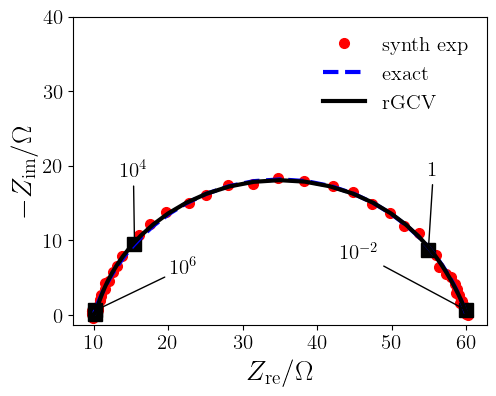

In [56]:
# compute the impedance
Z_DRT_rGCV = A@x_rGCV
Z_DRT_rGCV = Z_DRT_rGCV[0:N_freqs] + 1j*Z_DRT_rGCV[N_freqs:] 

# Nyquist plot of the impedance
plt.plot(np.real(Z_exp), -np.imag(Z_exp), 'o', markersize=7, color='red', label='synth exp')
plt.plot(np.real(Z_exp[5:81:16]), -np.imag(Z_exp[5:81:16]), 's', markersize=10, color='black')
plt.plot(np.real(Z_exact), -np.imag(Z_exact), '--', linewidth=3, color='blue', label='exact')
plt.plot(np.real(Z_DRT_rGCV), -np.imag(Z_DRT_rGCV), linewidth=3, color='black', label='rGCV')

plt.legend(frameon=False, fontsize = 15)
plt.axis('scaled')

plt.xticks(range(10, 70, 10))
plt.yticks(range(0, 50, 10))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)

plt.annotate(r'$10^{-2}$', xy=(np.real(Z_exp[5]), -np.imag(Z_exp[5])), 
             xytext=(np.real(Z_exp[5])-17, 7-np.imag(Z_exp[5])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$1$', xy=(np.real(Z_exp[21]), -np.imag(Z_exp[21])), 
             xytext=(np.real(Z_exp[21]), 10-np.imag(Z_exp[21])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$10^{4}$', xy=(np.real(Z_exp[37]), -np.imag(Z_exp[37])), 
             xytext=(np.real(Z_exp[37])-2, 9-np.imag(Z_exp[37])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$10^{6}$', xy=(np.real(Z_exp[53]), -np.imag(Z_exp[53])), 
             xytext=(np.real(Z_exp[53])+10, 5-np.imag(Z_exp[53])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))

fig = plt.gcf()
fig.set_size_inches(6.472, 4)
plt.show()

## 3.4 Re-im Discrepancy (re-im)

### 3.4.1 Computation of $\lambda_{\rm re-im}$

In [57]:
start_time = time.time()
cv_type = 're-im'
lambda_re_im = general_fun.optimal_lambda(A_re, A_im, Z_re, Z_im, M, log_lambda_0, cv_type)
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

     pcost       dcost       gap    pres   dres
 0: -1.0166e+05 -1.0207e+05  1e+03  1e+01  4e-03
 1: -1.0165e+05 -1.0178e+05  2e+02  1e+00  5e-04
 2: -1.0167e+05 -1.0170e+05  3e+01  6e-15  1e-16
 3: -1.0167e+05 -1.0168e+05  5e+00  5e-15  2e-16
 4: -1.0167e+05 -1.0168e+05  7e-01  4e-15  2e-16
 5: -1.0167e+05 -1.0167e+05  2e-01  4e-15  2e-16
 6: -1.0167e+05 -1.0167e+05  4e-02  3e-15  2e-16
 7: -1.0167e+05 -1.0167e+05  8e-03  4e-15  1e-16
 8: -1.0167e+05 -1.0167e+05  1e-03  3e-15  2e-16
 9: -1.0167e+05 -1.0167e+05  4e-05  3e-15  2e-16
10: -1.0167e+05 -1.0167e+05  1e-06  4e-15  2e-16
11: -1.0167e+05 -1.0167e+05  1e-08  6e-15  2e-16
12: -1.0167e+05 -1.0167e+05  1e-10  5e-15  2e-16
13: -1.0167e+05 -1.0167e+05  1e-12  3e-15  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.0285e+03 -4.1965e+03  7e+02  1e+01  1e-01
 1: -4.0255e+03 -4.1187e+03  1e+02  2e+00  2e-02
 2: -4.0390e+03 -4.0601e+03  2e+01  3e-02  4e-04
 3: -4.0448e+03 -4.0483e+03  4e+00  2e-03  2e-0

     pcost       dcost       gap    pres   dres
 0: -1.0166e+05 -1.0207e+05  1e+03  1e+01  4e-03
 1: -1.0165e+05 -1.0178e+05  2e+02  1e+00  5e-04
 2: -1.0167e+05 -1.0170e+05  3e+01  5e-15  2e-16
 3: -1.0167e+05 -1.0168e+05  5e+00  3e-15  2e-16
 4: -1.0167e+05 -1.0167e+05  7e-01  3e-15  2e-16
 5: -1.0167e+05 -1.0167e+05  2e-01  4e-15  2e-16
 6: -1.0167e+05 -1.0167e+05  5e-02  4e-15  2e-16
 7: -1.0167e+05 -1.0167e+05  1e-02  4e-15  2e-16
 8: -1.0167e+05 -1.0167e+05  3e-03  4e-15  2e-16
 9: -1.0167e+05 -1.0167e+05  1e-04  4e-15  2e-16
10: -1.0167e+05 -1.0167e+05  4e-06  6e-15  2e-16
11: -1.0167e+05 -1.0167e+05  2e-07  3e-15  1e-16
12: -1.0167e+05 -1.0167e+05  1e-08  4e-15  2e-16
13: -1.0167e+05 -1.0167e+05  1e-10  3e-15  2e-16
14: -1.0167e+05 -1.0167e+05  1e-12  2e-15  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.0284e+03 -4.1964e+03  7e+02  1e+01  1e-01
 1: -4.0251e+03 -4.1176e+03  1e+02  1e+00  2e-02
 2: -4.0389e+03 -4.0602e+03  2e+01  7e-02  8e-0

 6: -1.0167e+05 -1.0167e+05  5e-02  3e-15  2e-16
 7: -1.0167e+05 -1.0167e+05  1e-02  4e-15  2e-16
 8: -1.0167e+05 -1.0167e+05  3e-03  3e-15  2e-16
 9: -1.0167e+05 -1.0167e+05  1e-04  4e-15  1e-16
10: -1.0167e+05 -1.0167e+05  2e-06  6e-15  2e-16
11: -1.0167e+05 -1.0167e+05  2e-08  4e-15  1e-16
12: -1.0167e+05 -1.0167e+05  2e-10  3e-15  2e-16
13: -1.0167e+05 -1.0167e+05  2e-12  6e-15  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.0286e+03 -4.1967e+03  7e+02  1e+01  1e-01
 1: -4.0257e+03 -4.1194e+03  2e+02  2e+00  2e-02
 2: -4.0389e+03 -4.0606e+03  2e+01  2e-02  2e-04
 3: -4.0449e+03 -4.0484e+03  3e+00  7e-04  8e-06
 4: -4.0460e+03 -4.0467e+03  7e-01  9e-05  1e-06
 5: -4.0462e+03 -4.0465e+03  3e-01  9e-07  1e-08
 6: -4.0463e+03 -4.0464e+03  5e-02  2e-07  2e-09
 7: -4.0464e+03 -4.0464e+03  1e-02  2e-09  2e-11
 8: -4.0464e+03 -4.0464e+03  7e-04  7e-11  8e-13
 9: -4.0464e+03 -4.0464e+03  2e-05  2e-12  2e-14
10: -4.0464e+03 -4.0464e+03  7e-07  5e-13  4e-

 2: -4.0389e+03 -4.0606e+03  2e+01  2e-02  2e-04
 3: -4.0449e+03 -4.0484e+03  3e+00  7e-04  8e-06
 4: -4.0460e+03 -4.0467e+03  7e-01  9e-05  1e-06
 5: -4.0463e+03 -4.0465e+03  3e-01  9e-07  1e-08
 6: -4.0463e+03 -4.0464e+03  5e-02  2e-07  2e-09
 7: -4.0464e+03 -4.0464e+03  1e-02  2e-09  2e-11
 8: -4.0464e+03 -4.0464e+03  7e-04  8e-11  9e-13
 9: -4.0464e+03 -4.0464e+03  2e-05  2e-12  2e-14
10: -4.0464e+03 -4.0464e+03  7e-07  5e-13  4e-16
11: -4.0464e+03 -4.0464e+03  6e-08  5e-13  2e-16
12: -4.0464e+03 -4.0464e+03  8e-09  4e-12  1e-16
13: -4.0464e+03 -4.0464e+03  1e-09  3e-15  2e-16
14: -4.0464e+03 -4.0464e+03  2e-10  9e-10  1e-16
15: -4.0464e+03 -4.0464e+03  2e-11  3e-15  2e-16
16: -4.0464e+03 -4.0464e+03  4e-12  3e-15  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0166e+05 -1.0207e+05  1e+03  1e+01  4e-03
 1: -1.0165e+05 -1.0178e+05  2e+02  1e+00  5e-04
 2: -1.0167e+05 -1.0170e+05  3e+01  4e-15  2e-16
 3: -1.0167e+05 -1.0168e+05  5e+00  5e-15  2e-

10: -1.0167e+05 -1.0167e+05  2e-06  3e-15  2e-16
11: -1.0167e+05 -1.0167e+05  2e-08  6e-15  2e-16
12: -1.0167e+05 -1.0167e+05  2e-10  5e-15  2e-16
13: -1.0167e+05 -1.0167e+05  2e-12  3e-15  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.0287e+03 -4.1968e+03  7e+02  1e+01  1e-01
 1: -4.0259e+03 -4.1200e+03  2e+02  2e+00  2e-02
 2: -4.0385e+03 -4.0622e+03  2e+01  2e-02  2e-04
 3: -4.0450e+03 -4.0488e+03  4e+00  9e-04  1e-05
 4: -4.0461e+03 -4.0468e+03  7e-01  1e-04  1e-06
 5: -4.0464e+03 -4.0466e+03  2e-01  1e-06  1e-08
 6: -4.0465e+03 -4.0465e+03  5e-02  2e-07  2e-09
 7: -4.0465e+03 -4.0465e+03  1e-02  2e-09  2e-11
 8: -4.0465e+03 -4.0465e+03  8e-04  1e-10  1e-12
 9: -4.0465e+03 -4.0465e+03  1e-05  1e-12  2e-14
10: -4.0465e+03 -4.0465e+03  1e-07  5e-13  2e-16
11: -4.0465e+03 -4.0465e+03  1e-09  9e-13  1e-16
12: -4.0465e+03 -4.0465e+03  1e-11  9e-13  2e-16
13: -4.0465e+03 -4.0465e+03  1e-13  5e-13  1e-16
Optimal solution found.
     pcost       dcost

### 3.4.2 re-im based DRT and Impedance Recoveries

In [58]:
# enforce the non-negativity constraint on the DRT
lb = np.zeros([N_freqs+1])
bound_mat = np.eye(lb.shape[0]) 

# determination of x with cvxopt
H_combined, c_combined = general_fun.quad_format_combined(A_re, A_im, Z_re, Z_im, M, lambda_re_im)
start_time = time.time()
x_re_im = general_fun.cvxopt_solve_qpr(H_combined, c_combined, -bound_mat, lb) 

# determination of gamma
gamma_RR_re_im = general_fun.x_to_gamma(x_re_im[1:], tau_vec, tau_vec, expansion_type, epsilon) 
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

# error of the DRT approximation compared to gamma_exact
sq_err_re_im = norm(gamma_RR_re_im - gamma_exact)**2/norm(gamma_exact)**2 

     pcost       dcost       gap    pres   dres
 0: -1.0571e+05 -1.0610e+05  1e+03  1e+01  4e-03
 1: -1.0570e+05 -1.0582e+05  2e+02  1e+00  5e-04
 2: -1.0571e+05 -1.0574e+05  3e+01  3e-15  2e-16
 3: -1.0572e+05 -1.0572e+05  4e+00  4e-15  2e-16
 4: -1.0572e+05 -1.0572e+05  8e-01  3e-15  2e-16
 5: -1.0572e+05 -1.0572e+05  2e-01  3e-15  2e-16
 6: -1.0572e+05 -1.0572e+05  5e-02  3e-15  2e-16
 7: -1.0572e+05 -1.0572e+05  9e-03  4e-15  2e-16
 8: -1.0572e+05 -1.0572e+05  2e-03  4e-15  2e-16
 9: -1.0572e+05 -1.0572e+05  2e-04  3e-15  2e-16
10: -1.0572e+05 -1.0572e+05  6e-06  5e-15  2e-16
11: -1.0572e+05 -1.0572e+05  2e-07  3e-15  2e-16
12: -1.0572e+05 -1.0572e+05  6e-09  3e-15  2e-16
13: -1.0572e+05 -1.0572e+05  7e-11  6e-15  2e-16
Optimal solution found.
0.03865647315979004


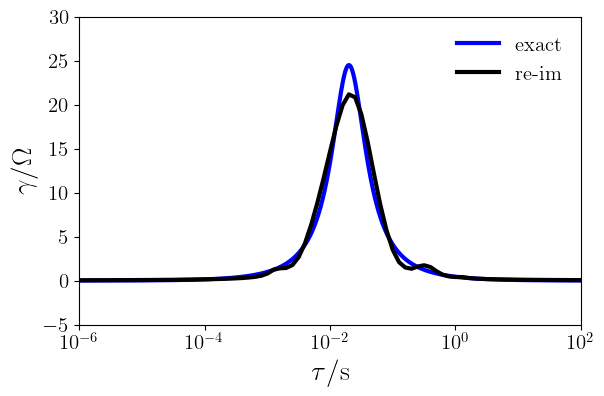

In [59]:
plt.semilogx(tau_vec_plot, gamma_exact_plot, linewidth=3, color='blue', label= 'exact')
plt.semilogx(tau_vec, gamma_RR_re_im, linewidth=3, color='black', label='re-im') 
plt.axis([1E-6,1E2,-5,30])
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.legend(frameon=False, fontsize = 15)
plt.xlabel('$\\tau/\\rm s$', fontsize=20)
plt.ylabel('$\\gamma/\\Omega$', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(6.472, 4)
plt.show()

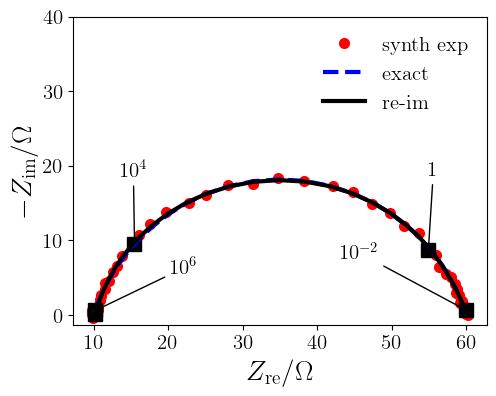

In [60]:
# compute the impedance
Z_DRT_re_im = A@x_re_im
Z_DRT_re_im = Z_DRT_re_im[0:N_freqs] + 1j*Z_DRT_re_im[N_freqs:]

# Nyquist plot of the impedance
plt.plot(np.real(Z_exp), -np.imag(Z_exp), 'o', markersize=7, color='red', label='synth exp')
plt.plot(np.real(Z_exp[5:81:16]), -np.imag(Z_exp[5:81:16]), 's', markersize=10, color='black')
plt.plot(np.real(Z_exact), -np.imag(Z_exact), '--', linewidth=3, color='blue', label='exact')
plt.plot(np.real(Z_DRT_re_im), -np.imag(Z_DRT_re_im), linewidth=3, color='black', label='re-im')

plt.legend(frameon=False, fontsize = 15)
plt.axis('scaled')

plt.xticks(range(10, 70, 10))
plt.yticks(range(0, 50, 10))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)

plt.annotate(r'$10^{-2}$', xy=(np.real(Z_exp[5]), -np.imag(Z_exp[5])), 
             xytext=(np.real(Z_exp[5])-17, 7-np.imag(Z_exp[5])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$1$', xy=(np.real(Z_exp[21]), -np.imag(Z_exp[21])), 
             xytext=(np.real(Z_exp[21]), 10-np.imag(Z_exp[21])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$10^{4}$', xy=(np.real(Z_exp[37]), -np.imag(Z_exp[37])), 
             xytext=(np.real(Z_exp[37])-2, 9-np.imag(Z_exp[37])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$10^{6}$', xy=(np.real(Z_exp[53]), -np.imag(Z_exp[53])), 
             xytext=(np.real(Z_exp[53])+10, 5-np.imag(Z_exp[53])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))

fig = plt.gcf()
fig.set_size_inches(6.472, 4)
plt.show()

## 3.5 k-fold CV

### 3.5.1 Computation of $\lambda_{\rm kf}$

In [61]:
start_time = time.time()
cv_type = 'kf'
lambda_kf = general_fun.optimal_lambda(A_re, A_im, Z_re, Z_im, M, log_lambda_0, cv_type)
end_time = time.time()
elapsed_time = end_time - start_time

print(elapsed_time)

TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 16 18 19 20 21 23 25 26 27 28
 30 31 32 34 36 37 38 39 40 41 42 43 44 47 48 49 50 51 52 54 56 57 58 59
 60 61 63 64 65 66 67 68 69 70 72 73 74 78 79 80] TEST: [ 9 15 17 22 24 29 33 35 45 46 53 55 62 71 75 76 77]
     pcost       dcost       gap    pres   dres
 0: -8.5945e+04 -8.6335e+04  1e+03  1e+01  5e-03
 1: -8.5940e+04 -8.6063e+04  2e+02  1e+00  6e-04
 2: -8.5953e+04 -8.5982e+04  3e+01  4e-15  1e-16
 3: -8.5960e+04 -8.5964e+04  4e+00  4e-15  1e-16
 4: -8.5961e+04 -8.5962e+04  9e-01  4e-15  1e-16
 5: -8.5961e+04 -8.5962e+04  3e-01  4e-15  2e-16
 6: -8.5961e+04 -8.5962e+04  5e-02  4e-15  1e-16
 7: -8.5961e+04 -8.5961e+04  9e-03  4e-15  1e-16
 8: -8.5961e+04 -8.5961e+04  7e-04  6e-15  1e-16
 9: -8.5961e+04 -8.5961e+04  1e-05  5e-15  1e-16
10: -8.5961e+04 -8.5961e+04  1e-07  5e-15  1e-16
11: -8.5961e+04 -8.5961e+04  1e-09  4e-15  1e-16
12: -8.5961e+04 -8.5961e+04  1e-11  4e-15  1e-16
Optimal solution found.
TRAIN: [ 0  1  3  4  5  6  7 

### 3.5.2 kf-based DRT and Impedance Recoveries

In [62]:
# enforce the non-negativity constraint on the DRT
lb = np.zeros([N_freqs+1])
bound_mat = np.eye(lb.shape[0]) 

# determination of x with cvxopt
H_combined, c_combined = general_fun.quad_format_combined(A_re, A_im, Z_re, Z_im, M, lambda_kf)
start_time = time.time()
x_kf = general_fun.cvxopt_solve_qpr(H_combined, c_combined, -bound_mat, lb) 

# determination of gamma
gamma_RR_kf = general_fun.x_to_gamma(x_kf[1:], tau_vec, tau_vec, expansion_type, epsilon) 
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

# error of the DRT approximation compared to gamma_exact
sq_err_kf = norm(gamma_RR_kf - gamma_exact)**2/norm(gamma_exact)**2 

     pcost       dcost       gap    pres   dres
 0: -1.0571e+05 -1.0610e+05  1e+03  1e+01  4e-03
 1: -1.0570e+05 -1.0582e+05  2e+02  1e+00  5e-04
 2: -1.0571e+05 -1.0574e+05  3e+01  6e-15  2e-16
 3: -1.0572e+05 -1.0572e+05  4e+00  4e-15  2e-16
 4: -1.0572e+05 -1.0572e+05  8e-01  4e-15  2e-16
 5: -1.0572e+05 -1.0572e+05  2e-01  4e-15  2e-16
 6: -1.0572e+05 -1.0572e+05  5e-02  6e-15  2e-16
 7: -1.0572e+05 -1.0572e+05  9e-03  5e-15  2e-16
 8: -1.0572e+05 -1.0572e+05  2e-03  4e-15  1e-16
 9: -1.0572e+05 -1.0572e+05  3e-04  5e-15  2e-16
10: -1.0572e+05 -1.0572e+05  1e-05  4e-15  2e-16
11: -1.0572e+05 -1.0572e+05  3e-07  3e-15  2e-16
12: -1.0572e+05 -1.0572e+05  1e-08  4e-15  2e-16
13: -1.0572e+05 -1.0572e+05  2e-10  5e-15  2e-16
14: -1.0572e+05 -1.0572e+05  2e-12  4e-15  2e-16
Optimal solution found.
0.03799748420715332


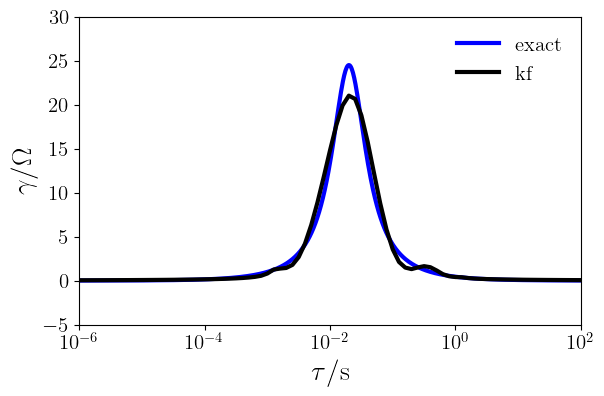

In [63]:
plt.semilogx(tau_vec_plot, gamma_exact_plot, linewidth=3, color='blue', label= 'exact')
plt.semilogx(tau_vec, gamma_RR_kf, linewidth=3, color='black', label='kf') 
plt.axis([1E-6,1E2,-5,30])
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.legend(frameon=False, fontsize = 15)
plt.xlabel('$\\tau/\\rm s$', fontsize=20)
plt.ylabel('$\\gamma/\\Omega$', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(6.472, 4)
plt.show()

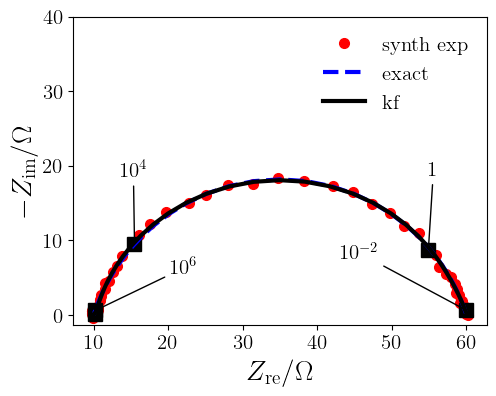

In [64]:
# compute the impedance
Z_DRT_kf = A@x_kf
Z_DRT_kf = Z_DRT_kf[0:N_freqs] + 1j*Z_DRT_kf[N_freqs:] 

# Nyquist plot of the impedance
plt.plot(np.real(Z_exp), -np.imag(Z_exp), 'o', markersize=7, color='red', label='synth exp')
plt.plot(np.real(Z_exp[5:81:16]), -np.imag(Z_exp[5:81:16]), 's', markersize=10, color='black')
plt.plot(np.real(Z_exact), -np.imag(Z_exact), '--', linewidth=3, color='blue', label='exact')
plt.plot(np.real(Z_DRT_kf), -np.imag(Z_DRT_kf), linewidth=3, color='black', label='kf')
plt.legend(frameon=False, fontsize = 15)
plt.axis('scaled')

plt.xticks(range(10, 70, 10))
plt.yticks(range(0, 50, 10))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)

plt.annotate(r'$10^{-2}$', xy=(np.real(Z_exp[5]), -np.imag(Z_exp[5])), 
             xytext=(np.real(Z_exp[5])-17, 7-np.imag(Z_exp[5])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$1$', xy=(np.real(Z_exp[21]), -np.imag(Z_exp[21])), 
             xytext=(np.real(Z_exp[21]), 10-np.imag(Z_exp[21])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$10^{4}$', xy=(np.real(Z_exp[37]), -np.imag(Z_exp[37])), 
             xytext=(np.real(Z_exp[37])-2, 9-np.imag(Z_exp[37])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$10^{6}$', xy=(np.real(Z_exp[53]), -np.imag(Z_exp[53])), 
             xytext=(np.real(Z_exp[53])+10, 5-np.imag(Z_exp[53])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))

fig = plt.gcf()
fig.set_size_inches(6.472, 4)
plt.show()

## 3.6 L-curve (LC)

### 3.6.1 Computation of $\lambda_{\rm LC}$

In [65]:
start_time = time.time()
cv_type = 'LC'
lambda_LC = general_fun.optimal_lambda(A_re, A_im, Z_re, Z_im, M, log_lambda_0, cv_type)

end_time = time.time()
elapsed_time = end_time - start_time

print(elapsed_time)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -145.02111845453632
            Iterations: 5
            Function evaluations: 2
            Gradient evaluations: 1
LC
0.005999326705932617


### 3.6.2 LC-based DRT and Impedance Recoveries 

In [66]:
# enforce the non-negativity constraint on the DRT
lb = np.zeros([N_freqs+1])
bound_mat = np.eye(lb.shape[0]) 

# determination of x with cvxopt
H_combined, c_combined = general_fun.quad_format_combined(A_re, A_im, Z_re, Z_im, M, lambda_LC)
start_time = time.time()
x_LC = general_fun.cvxopt_solve_qpr(H_combined, c_combined, -bound_mat, lb) 

# determination of gamma
gamma_RR_LC = general_fun.x_to_gamma(x_LC[1:], tau_vec, tau_vec, expansion_type, epsilon) 
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

# error of the DRT approximation compared to gamma_exact
sq_err_LC = norm(gamma_RR_LC - gamma_exact)**2/norm(gamma_exact)**2 

     pcost       dcost       gap    pres   dres
 0: -1.0571e+05 -1.0610e+05  1e+03  1e+01  4e-03
 1: -1.0570e+05 -1.0582e+05  2e+02  1e+00  5e-04
 2: -1.0571e+05 -1.0574e+05  3e+01  6e-15  2e-16
 3: -1.0572e+05 -1.0572e+05  4e+00  4e-15  2e-16
 4: -1.0572e+05 -1.0572e+05  8e-01  4e-15  2e-16
 5: -1.0572e+05 -1.0572e+05  2e-01  4e-15  2e-16
 6: -1.0572e+05 -1.0572e+05  5e-02  6e-15  2e-16
 7: -1.0572e+05 -1.0572e+05  9e-03  5e-15  2e-16
 8: -1.0572e+05 -1.0572e+05  2e-03  4e-15  1e-16
 9: -1.0572e+05 -1.0572e+05  3e-04  5e-15  2e-16
10: -1.0572e+05 -1.0572e+05  1e-05  4e-15  2e-16
11: -1.0572e+05 -1.0572e+05  3e-07  3e-15  2e-16
12: -1.0572e+05 -1.0572e+05  1e-08  4e-15  2e-16
13: -1.0572e+05 -1.0572e+05  2e-10  5e-15  2e-16
14: -1.0572e+05 -1.0572e+05  2e-12  4e-15  2e-16
Optimal solution found.
0.03932499885559082


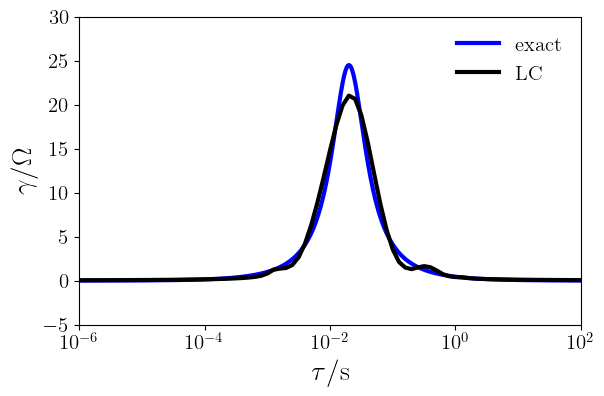

In [67]:
plt.semilogx(tau_vec_plot, gamma_exact_plot, linewidth=3, color='blue', label= 'exact')
plt.semilogx(tau_vec, gamma_RR_LC, linewidth=3, color='black', label='LC') 
plt.axis([1E-6,1E2,-5,30])
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.legend(frameon=False, fontsize = 15, loc='upper right')
plt.xlabel('$\\tau/\\rm s$', fontsize=20)
plt.ylabel('$\\gamma/\\Omega$', fontsize=20)
fig = plt.gcf()
fig.set_size_inches(6.472, 4)
plt.show()

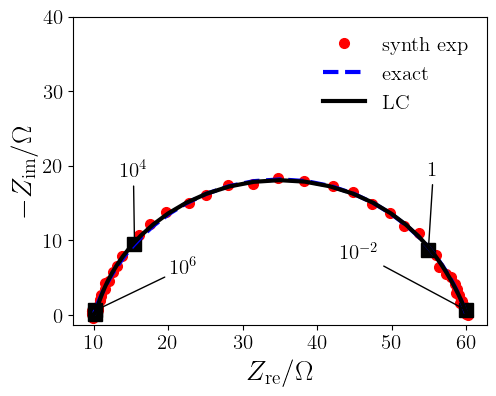

In [68]:
# compute impedance
Z_DRT_LC = A@x_LC
Z_DRT_LC = Z_DRT_LC[0:N_freqs] + 1j*Z_DRT_LC[N_freqs:] 

# Nyquist plot of the impedance
plt.plot(np.real(Z_exp), -np.imag(Z_exp), 'o', markersize=7, color='red', label='synth exp')
plt.plot(np.real(Z_exp[5:81:16]), -np.imag(Z_exp[5:81:16]), 's', markersize=10, color='black')
plt.plot(np.real(Z_exact), -np.imag(Z_exact), '--', linewidth=3, color='blue', label='exact')
plt.plot(np.real(Z_DRT_LC), -np.imag(Z_DRT_LC), linewidth=3, color='black', label='LC')
plt.legend(frameon=False, fontsize = 15)
plt.axis('scaled')

plt.xticks(range(10, 70, 10))
plt.yticks(range(0, 50, 10))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)

plt.annotate(r'$10^{-2}$', xy=(np.real(Z_exp[5]), -np.imag(Z_exp[5])), 
             xytext=(np.real(Z_exp[5])-17, 7-np.imag(Z_exp[5])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$1$', xy=(np.real(Z_exp[21]), -np.imag(Z_exp[21])), 
             xytext=(np.real(Z_exp[21]), 10-np.imag(Z_exp[21])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$10^{4}$', xy=(np.real(Z_exp[37]), -np.imag(Z_exp[37])), 
             xytext=(np.real(Z_exp[37])-2, 9-np.imag(Z_exp[37])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))
plt.annotate(r'$10^{6}$', xy=(np.real(Z_exp[53]), -np.imag(Z_exp[53])), 
             xytext=(np.real(Z_exp[53])+10, 5-np.imag(Z_exp[53])), 
             arrowprops=dict(arrowstyle='-',connectionstyle='arc'))

fig = plt.gcf()
fig.set_size_inches(6.472, 4)
plt.show()